<a href="https://colab.research.google.com/github/karri-ten/VibeScope/blob/main/VibeScope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VibeScope _ Analysing online vibe through NLP

VibeScope analyzes Twitter conversations in real time, using NLP and machine learning to extract and interpret sentiment trends. It provides insights on topics, brands, and events while leveraging automated data pipelines and interactive dashboards to enhance understanding of public opinion.

In [6]:
# Install Tweepy (v4.10+ for API v2 Support)
!pip install tweepy matplotlib pandas numpy seaborn plotly
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


# Scrapping tweet from Twitter (Real-Time)

In [2]:
# Authenticate and Initialize Client
import tweepy
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from google.colab import userdata



In [9]:
# Retrieve all necessary credentials from Google Colab secrets
bearer_token = userdata.get("BEARER_TOKEN")
consumer_key = userdata.get("API_key")
consumer_secret = userdata.get("API_key_secret")
access_token = userdata.get("Access_Token")
access_token_secret = userdata.get("Access_Token_Secret")

if any(token is None for token in [bearer_token, consumer_key, consumer_secret, access_token, access_token_secret]):
    raise ValueError("One or more Twitter API secrets are missing.")

# Initialize tweepy client
client = tweepy.Client(
    bearer_token=bearer_token,
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    wait_on_rate_limit=True
)

In [11]:
# fetching of tweets
def fetch_tweets(query, num_tweets=100, client=client):
    tweets_data = []
    paginator = tweepy.Paginator(
        client.search_recent_tweets,
        query=query,
        max_results=10,
        tweet_fields=["created_at", "public_metrics", "author_id"],
        user_fields=["username"],
        expansions=["author_id"],
        limit=max(1, (num_tweets // 10))
    )
    for tweet in paginator.flatten(limit=num_tweets):
        tweets_data.append({
            "text": tweet.text,
            "created_at": tweet.created_at,
            "likes": tweet.public_metrics["like_count"],
            "retweets": tweet.public_metrics["retweet_count"],
            "author_id": tweet.author_id
        })
    return pd.DataFrame(tweets_data)

In [12]:
#  Interactive Widgets for Query & Tweet Count
keyword_widget = widgets.Text(
    value='ChatGPT',
    placeholder='Type a keyword or hashtag',
    description='Keyword:'
)
tweet_count_widget = widgets.IntSlider(
    value=100,
    min=10,
    max=1000,
    step=10,
    description='Num Tweets:'
)
display(keyword_widget, tweet_count_widget)

Text(value='ChatGPT', description='Keyword:', placeholder='Type a keyword or hashtag')

IntSlider(value=100, description='Num Tweets:', max=1000, min=10, step=10)

In [ ]:
#Fetch and Display Tweets Using Function and Widgets
query = f"{keyword_widget.value} lang:en -is:retweet"
num_tweets = tweet_count_widget.value

df = fetch_tweets(query, num_tweets)
print(f"Fetched {len(df)} tweets.")
df.head()

In [ ]:
# Save the results to CSV if needed
df.to_csv(f"tweets_{keyword_widget.value}.csv", index=False)

# Using dowloaded twitter dataset (US Election 2020 Tweets) from Kaggle

##Setting up & Data Pipeline (Kaggle + Colab)

In [1]:
# Install the kaggle package
!pip install kaggle
import os

# Upload your kaggle.json (from Kaggle API) using Colab left sidebar or:
from google.colab import files
files.upload()
# Ensure kaggle.json is uploaded before running this cell


# Configure Kaggle CLI
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Election 2020 Tweets dataset using Kaggle CLI
dataset_slug = "manchunhui/us-election-2020-tweets"
!kaggle datasets download {dataset_slug}

# Unzip the downloaded file (it will be a zip file with the dataset slug name)
unzip_command = f"unzip {dataset_slug.split('/')[-1]}.zip"
!{unzip_command}


path = "." # Or the specific subdirectory if unzip created one

print(f"Files should now be in the current directory: {os.getcwd()}")
print("Listing contents of current directory:")
!ls

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets
License(s): CC0-1.0
 97% 344M/353M [00:06<00:00, 49.3MB/s]
100% 353M/353M [00:06<00:00, 59.2MB/s]
Archive:  us-election-2020-tweets.zip
  inflating: hashtag_donaldtrump.csv  
  inflating: hashtag_joebiden.csv    
Files should now be in the current directory: /content
Listing contents of current directory:
hashtag_donaldtrump.csv  kaggle.json  us-election-2020-tweets.zip
hashtag_joebiden.csv	 sample_data


Loading the Data for “Real-time” Analysis

In [2]:
import pandas as pd
import os

biden_file_path = '/content/hashtag_joebiden.csv'
trump_file_path = '/content/hashtag_donaldtrump.csv'

# Check if files exist before trying to read
if not os.path.exists(biden_file_path):
    raise FileNotFoundError(f"Expected file not found: {biden_file_path}")
if not os.path.exists(trump_file_path):
    raise FileNotFoundError(f"Expected file not found: {trump_file_path}")

# Load tweets for both major candidates using the filenames
# Try specifying the 'python' engine and handling bad lines
try:
    biden = pd.read_csv(biden_file_path, engine='python', on_bad_lines='skip')
    print(f"Successfully loaded {biden_file_path}")
except Exception as e:
    print(f"Error loading {biden_file_path}: {e}")
    # Potentially try different parsing options or investigate the file
    raise

try:
    trump = pd.read_csv(trump_file_path, engine='python', on_bad_lines='skip')
    print(f"Successfully loaded {trump_file_path}")
except Exception as e:
    print(f"Error loading {trump_file_path}: {e}")
    # Potentially try different parsing options or investigate the file
    raise




Successfully loaded /content/hashtag_joebiden.csv
Successfully loaded /content/hashtag_donaldtrump.csv


In [3]:
# Load the Election Tweets Dataset
import pandas as pd


# Load datasets
df_biden = pd.read_csv('/content/hashtag_joebiden.csv', engine='python', on_bad_lines='skip')
print(f"Successfully loaded /content/hashtag_joebiden.csv")

df_trump = pd.read_csv('/content/hashtag_donaldtrump.csv', engine='python', on_bad_lines='skip')
print(f"Successfully loaded /content/hashtag_donaldtrump.csv")

# Add a 'candidate' column to each DataFrame
df_biden['candidate'] = 'Biden'
df_trump['candidate'] = 'Trump'

# Quick look at the data
print("\nBiden sample:")
display(df_biden.head(2))
print("\nTrump sample:")
display(df_trump.head(2))


Successfully loaded /content/hashtag_joebiden.csv
Successfully loaded /content/hashtag_donaldtrump.csv

Biden sample:


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:18,1.31652929585929e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,Biden



Trump sample:


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump


In [4]:
# For real-time simulation, sample in chunks
chunk_size = 500  # You can adjust this for "real-time" batch simulation

# Ensuring sampling does not exceed the number of rows actually loaded
biden_sample_size = min(chunk_size, len(df_biden))
trump_sample_size = min(chunk_size, len(df_trump))

if biden_sample_size > 0:
    biden_sample = df_biden.sample(biden_sample_size, random_state=1)
else:
    biden_sample = pd.DataFrame(columns=df_biden.columns) # Create empty DataFrame with same columns

if trump_sample_size > 0:
    trump_sample = df_trump.sample(trump_sample_size, random_state=1)
else:
    trump_sample = pd.DataFrame(columns=df_trump.columns) # Create empty DataFrame with same columns

# Combined for joint analysis
# Checking if samples are not empty before concatenating
if not biden_sample.empty or not trump_sample.empty:
    tweets = pd.concat([biden_sample, trump_sample], ignore_index=True)
    if not tweets.empty:
        tweets = tweets.sample(frac=1, random_state=2).reset_index(drop=True)  # shuffle
    else:
        print("Concatenated DataFrame is empty.")
else:
    tweets = pd.DataFrame() # Create empty DataFrame if both samples are empty
    print("Both sample DataFrames are empty.")


In [5]:
# Cleaning of tweets
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()


if not tweets.empty:
    tweets['clean_text'] = tweets['tweet'].apply(clean_text)
    print("Cleaned text column created.")
    print(tweets[['candidate', 'tweet', 'clean_text']].head(3))
else:
    print("The 'tweets' DataFrame is empty. Cannot create 'clean_text' column.")



Cleaned text column created.
  candidate                                              tweet  \
0     Biden  One #Republican governor voted for #Biden. Ano...   
1     Trump  Just heard #Trump say “This is a national emba...   
2     Trump  I just thot of something\n\n@realDonaldTrump h...   

                                          clean_text  
0  one republican governor voted for biden anothe...  
1  just heard trump say this is a national embarr...  
2  i just thot of something\n\n has\nkompromat on...  


In [7]:
# Sentiment Analysis with VADER

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

tweets['sentiment'] = tweets['clean_text'].apply(get_sentiment)
tweets['sentiment'].value_counts()


,count
sentiment,
neutral,467
positive,286
negative,247


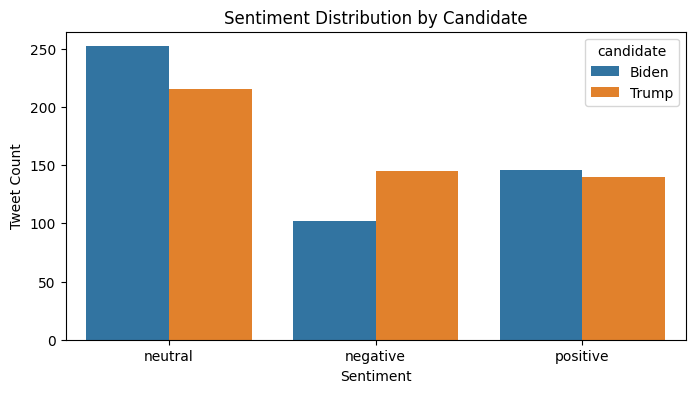

In [8]:
# Visualize Sentiment by Candidate
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=tweets, x='sentiment', hue='candidate')
plt.title('Sentiment Distribution by Candidate')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()


In [9]:
# Top Hashtags per Candidate
from collections import Counter

def extract_hashtags(text):
    return re.findall(r'#\w+', str(text).lower())

tweets['hashtags'] = tweets['tweet'].apply(extract_hashtags)

for candidate in ['Biden', 'Trump']:
    c_hashtags = sum(tweets[tweets['candidate']==candidate]['hashtags'], [])
    top_tags = Counter(c_hashtags).most_common(10)
    print(f"Top 10 hashtags for {candidate}:")
    print(top_tags)


Top 10 hashtags for Biden:
[('#biden', 319), ('#joebiden', 198), ('#trump', 128), ('#election2020', 60), ('#elections2020', 34), ('#kamalaharris', 30), ('#bidenharris2020', 30), ('#donaldtrump', 22), ('#vote', 19), ('#biden2020', 18)]
Top 10 hashtags for Trump:
[('#trump', 442), ('#biden', 84), ('#donaldtrump', 74), ('#election2020', 48), ('#trump2020', 33), ('#elections2020', 32), ('#joebiden', 29), ('#usa', 22), ('#electionday', 21), ('#maga', 16)]


In [11]:
# Interactive Plot with Plotly
import plotly.express as px

fig = px.histogram(tweets, x='sentiment', color='candidate',
                   barmode='group', title='Sentiment by Candidate (Interactive)')
fig.show()


In [12]:
# Tweets Example  for Each Sentiment
for candidate in ['Biden', 'Trump']:
    print(f"\nSample Positive Tweets for {candidate}:")
    print(tweets[(tweets['candidate']==candidate) & (tweets['sentiment']=='positive')]['tweet'].head(2).values)



Sample Positive Tweets for Biden:
['So happy for all my American friends and followers!\n\n💙🍾🥂🇺🇸\n\n-\n-\n-\n-\n\n#joebiden #kamalaharris #presidentbiden #vicepresidentharris #america #makeamericagreatagain #presidentialdebate https://t.co/jpQ1zaIQqG'
 '@realDonaldTrump When #Biden is in office from next #January;\n\nI HOPE he asks #Obama to the #WhiteHouse a LOT,\n\nJUST TO PISS YOU OFF!🤣']

Sample Positive Tweets for Trump:
['BTW... IM HAVING A #TRUMP PARTY... Been CELEBRATING ALLDAY!!\nSOOO...#TRUMP DON’T WANT TO LEAVE ..THE PEOPLE HOUSE!!  WE KNOW..WHY #TRUMP WANT LEAVE!!!\n\nTick..Tock⏰'
 '@IngrahamAngle @newtgingrich @QuakeMedia Donald Trump has been a failure at everything he’s ever done in his life except for two things:\n\n1. Convincing his ignorant supporters he’s one of them.\n\n2. Getting away with committing crimes.\n\n#VoteOutEveryRepublican \n#TrumpCrimeFamily \n#DonaldTrump \n\nhttps://t.co/VT1pkDc69x']


Deployment using Streamlit

In [17]:
!pip install gradio

In [ ]:
import gradio as gr
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Cleaning function
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()

# Sentiment function
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Main Gradio function
def analyze_sentiment(csv_file):
    df = pd.read_csv(csv_file)
    if 'text' not in df.columns:
        return "Your CSV must have a 'text' column!"
    df['clean_text'] = df['text'].apply(clean_text)
    df['sentiment'] = df['clean_text'].apply(get_sentiment)

    summary = df['sentiment'].value_counts().to_frame('count')
    summary = summary.reset_index().rename(columns={'index': 'sentiment'})

    # Example tweets
    examples = {}
    for sent in ['positive', 'negative', 'neutral']:
        examples[sent] = df[df['sentiment']==sent]['text'].head(2).tolist()

    out = "### Sentiment Counts\n"
    out += summary.to_markdown(index=False)
    out += "\n\n"
    for sent in examples:
        out += f"**{sent.capitalize()} Examples:**\n"
        out += '\n'.join(f"- {tweet}" for tweet in examples[sent]) + '\n\n'
    return out

# Gradio interface
iface = gr.Interface(
    fn=analyze_sentiment,
    inputs=gr.File(label="Upload Twitter CSV (with 'text' column)"),
    outputs="markdown",
    title="VibeScope: Election Twitter Sentiment Analyzer",
    description="Upload your US Election 2020 Twitter dataset CSV to analyze the sentiment using NLP."
)

iface.launch(share=True)  # share=True gives you a public link!
